In [1]:
import torch, random
import torchvision
from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import json, string
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib inline


In [37]:
# delete the file that cannot be opened
import os
for path, subdirs, files in os.walk('/home/ningjy/jianyusu/Image_recognition/cs6501_final_project/all_data_w_splits/'):
    for name in files:
        file = os.path.join(path, name)
        with open(file, 'rb') as f:
            try:
                Image.open(f).convert('RGB')
            except IOError as e:  
                os.remove(file)

In [2]:
# Read data from my local machine and it works this way
# root/1/xxx.png
# root/1/xxy.png
# root/1/xxz.png

# root/2/123.png
# root/2/nsdf3.png
# root/2/asd932_.png

imgTransform = transforms.Compose([transforms.Scale(224),
                                   transforms.RandomCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                        (0.2023, 0.1994, 0.2010))])

CFTrainSet = torchvision.datasets.ImageFolder(root = "./all_data_w_splits/train", transform = imgTransform)
CFValSet = torchvision.datasets.ImageFolder(root = "./all_data_w_splits/val", transform = imgTransform)

CFTrainLoader = torch.utils.data.DataLoader(CFTrainSet, batch_size = 16, 
                                          shuffle = True, num_workers = 2)
CFValLoader = torch.utils.data.DataLoader(CFValSet, batch_size = 16, 
                                          shuffle = True, num_workers = 2)

In [11]:
model = torchvision.models.vgg11_bn(pretrained=True)

# Feel free to use a different loss here.
criterion = nn.CrossEntropyLoss()

learningRate = 1e-2

# Feel free to change the optimizer, or the optimizer parameters. e.g. momentum, weightDecay, etc.
optimizer = optim.SGD(model.parameters(), lr = learningRate)

In [14]:
print(model)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU (inplace)
    (7): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU (inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (13): ReLU (inplace)
    (14): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): BatchNorm2d(512, eps=1e-

In [7]:
# Train the previously defined model.
def train_model(network, criterion, optimizer, checkPoint, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    train_acc = list()
    val_acc = list()
    train_loss = list()
    val_loss = list()
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        train_loss.append(cum_loss / (1 + i))
        train_acc.append(100 * correct / counter)
        torch.save({
            'epoch': epoch + 1,
            'state_dict': network.state_dict(),
        }, checkPoint + '.tar' )

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        val_loss.append(cum_loss / (1 + i))
        val_acc.append(100 * correct / counter)
        
        epochs = np.arange(0.0, n_epochs, 1.0)

    plt.figure(1)
    plt.subplot(211)
    plt.plot(epochs, train_acc, '-o', label = 'train_acc' )
    plt.plot(epochs, val_acc, '-o', label = 'validate_acc')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(212)
    plt.plot(epochs, train_loss, '-o', label = 'train_loss')
    plt.plot(epochs, val_loss, '-o', label = 'validate_loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.tight_layout()
    plt.show()
        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

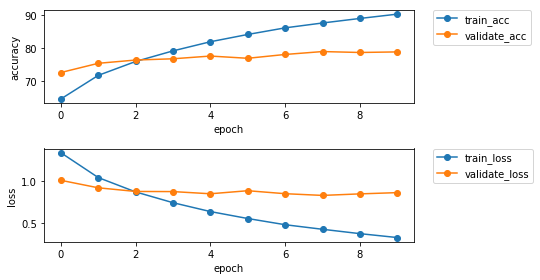

In [40]:

train_model(model, criterion, optimizer, CFTrainLoader, CFValLoader, n_epochs = 10, use_gpu = True)

In [8]:
scratchModel = torchvision.models.vgg11_bn(pretrained=False)

# Feel free to use a different loss here.
criterion = nn.CrossEntropyLoss()

learningRate = 1e-2

# Feel free to change the optimizer, or the optimizer parameters. e.g. momentum, weightDecay, etc.
scratchOptimizer = optim.SGD(scratchModel.parameters(), lr = learningRate)
checkPoint = 'scratchCheckPoint'

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

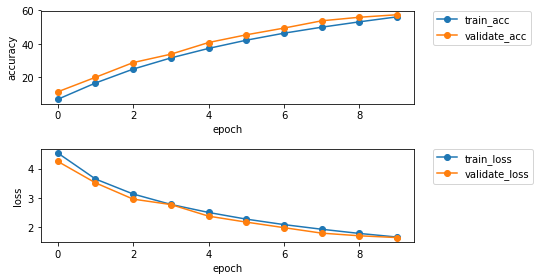

In [9]:
train_model(scratchModel, criterion, scratchOptimizer, checkPoint, CFTrainLoader, CFValLoader, n_epochs = 10, use_gpu = True)